In [7]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


print(tf.__version__)

2.10.1


In [8]:
data_directory = r'D:\Machine Learning Projects\Chest X-Ray Images\chest_xray\data'

In [9]:
#0 is normal, 1 is pneumonia
data = tf.keras.utils.image_dataset_from_directory(data_directory)

Found 5856 files belonging to 2 classes.


In [10]:
data_iterator = data.as_numpy_iterator()

In [11]:
batch = data_iterator.next()

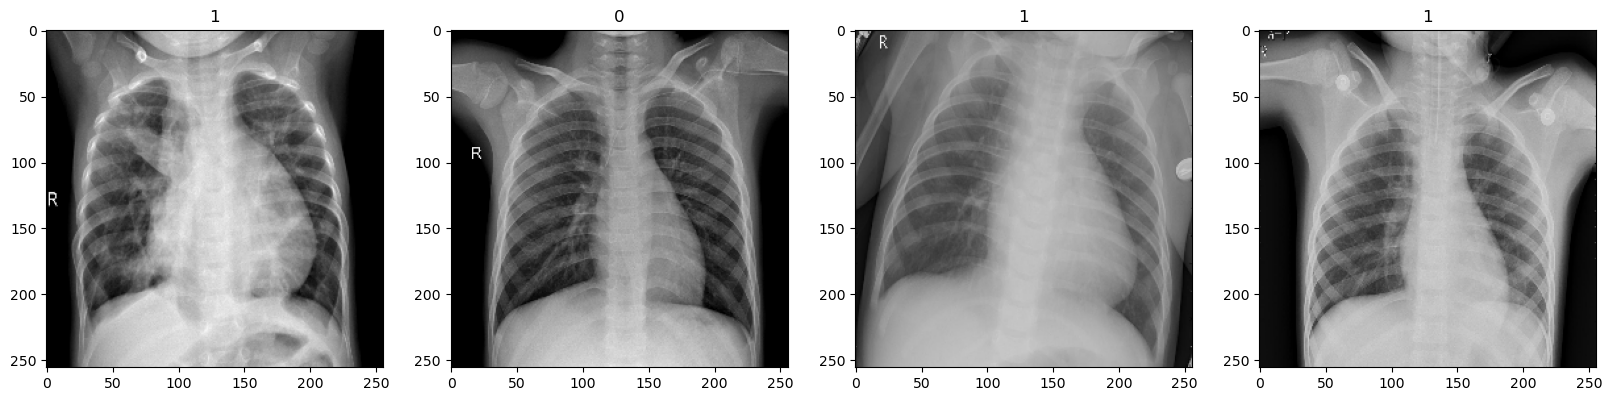

In [12]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(np.uint8))
    ax[idx].set_title(batch[1][idx])

In [13]:
data = data.map(lambda x, y: (x/255.0, y))

In [14]:
len(data)

183

In [15]:
train_size = int(0.7 * len(data))
val_size = int(0.2 * len(data))
test_size = int(0.1 * len(data)) + 1

print(train_size, val_size, test_size)
print(train_size + val_size + test_size)

128 36 19
183


In [16]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size).skip(val_size).take(test_size)

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

In [18]:
model = Sequential()

In [19]:
model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [20]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [22]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [23]:
from keras.callbacks import EarlyStopping

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=5,
    verbose=1,
    mode='auto'
)

In [24]:
hist = model.fit(train, validation_data=val, epochs=100, callbacks=[tensorboard_callback, earlystop])

Epoch 1/100
128/128 [==============================] - 12s 62ms/step - loss: 0.3118 - accuracy: 0.8657 - val_loss: 0.2336 - val_accuracy: 0.8976
Epoch 2/100
128/128 [==============================] - 8s 64ms/step - loss: 0.1597 - accuracy: 0.9407 - val_loss: 0.1679 - val_accuracy: 0.9410
Epoch 3/100
128/128 [==============================] - 8s 62ms/step - loss: 0.1407 - accuracy: 0.9485 - val_loss: 0.1742 - val_accuracy: 0.9332
Epoch 4/100
128/128 [==============================] - 8s 62ms/step - loss: 0.1218 - accuracy: 0.9539 - val_loss: 0.1369 - val_accuracy: 0.9479
Epoch 5/100
128/128 [==============================] - 8s 63ms/step - loss: 0.1070 - accuracy: 0.9629 - val_loss: 0.1245 - val_accuracy: 0.9549
Epoch 6/100
128/128 [==============================] - 8s 62ms/step - loss: 0.0915 - accuracy: 0.9678 - val_loss: 0.1195 - val_accuracy: 0.9575
Epoch 7/100
128/128 [==============================] - 8s 61ms/step - loss: 0.0820 - accuracy: 0.9717 - val_loss: 0.1378 - val_accuracy

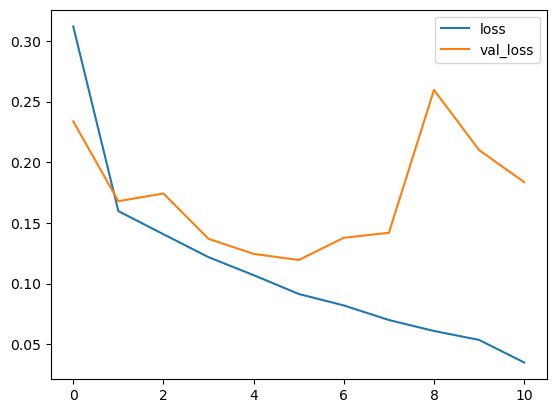

In [25]:
fig = plt.figure()
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [26]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [27]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [30]:
for batch in test.as_numpy_iterator():
    x, y = batch
    y_pred = model.predict(x)
    pre.update_state(y, y_pred)
    re.update_state(y, y_pred)
    acc.update_state(y, y_pred)

1/1 [==============================] - 0s 23ms/step


In [31]:
print('Precision: ', pre.result().numpy()), print('Recall: ', re.result().numpy()), print('Accuracy: ', acc.result().numpy())

Precision:  0.93868923
Recall:  0.98447895
Accuracy:  0.94078946


(None, None, None)

In [33]:
import os
from tensorflow.keras.models import load_model
model.save(os.path.join('models', 'model_second.h5'))